Imports OK

Loaded sensor_output.fits (256, 256)
Loaded final_combined_psf.fits (256, 256)
Loaded star_catalog.json with 2151 entries
Peaks found: 1
Refined centroids: [(np.float64(126.57592429544391), np.float64(126.56044177478783))]


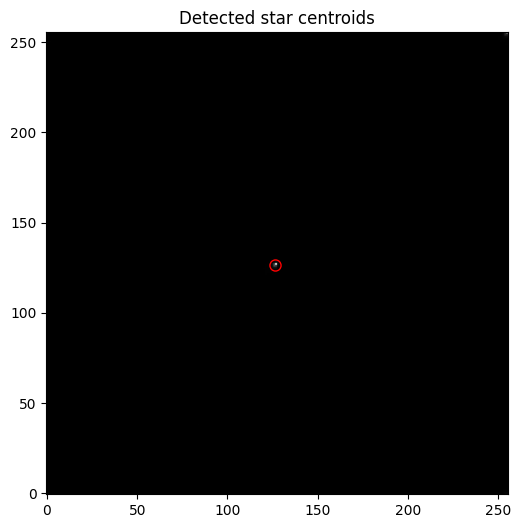

Photometry done = 1
Saved photometry_results.csv


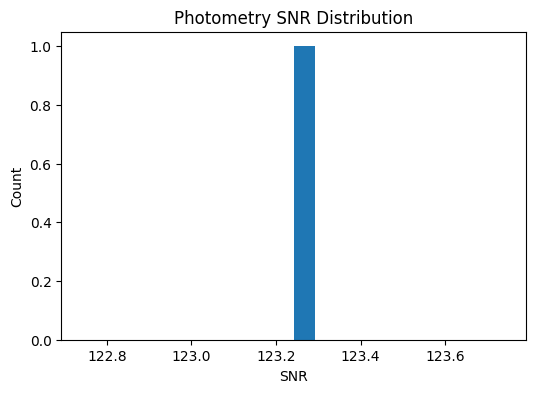

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass, gaussian_filter
from astropy.io import fits
import json, csv, os

print("Imports OK\n")


# -----------------------------------------------------------
# 1. Load FITS files
# -----------------------------------------------------------

def load_fits(path):
    if not os.path.exists(path):
        print("❌ Missing:", path)
        return None
    data = fits.getdata(path).astype(np.float32)
    print("Loaded", path, data.shape)
    return data

img = load_fits("sensor_output.fits")
psf = load_fits("final_combined_psf.fits")

with open("star_catalog.json") as f:
    catalog = json.load(f)
print("Loaded star_catalog.json with", len(catalog), "entries")


# -----------------------------------------------------------
# 2. Peak Detection
# -----------------------------------------------------------

def detect_peaks(image, threshold_sigma=5):
    smoothed = gaussian_filter(image, 1.0)
    thresh = np.mean(smoothed) + threshold_sigma * np.std(smoothed)
    peaks = []

    for y in range(1, smoothed.shape[0]-1):
        for x in range(1, smoothed.shape[1]-1):
            if smoothed[y,x] > thresh and smoothed[y,x] == np.max(smoothed[y-1:y+2, x-1:x+2]):
                peaks.append((y,x))
    return peaks

peaks = detect_peaks(img)
print("Peaks found:", len(peaks))


# -----------------------------------------------------------
# 3. Centroid Refinement
# -----------------------------------------------------------

def refine_centroid(image, y, x, r=3):
    y0, y1 = max(0, y-r), min(image.shape[0], y+r+1)
    x0, x1 = max(0, x-r), min(image.shape[1], x+r+1)
    sub = image[y0:y1, x0:x1]
    cy, cx = center_of_mass(sub)
    return (y0 + cy, x0 + cx)

centroids = [refine_centroid(img, y, x) for (y,x) in peaks]
print("Refined centroids:", centroids)


# -----------------------------------------------------------
# 4. Plot Detected Centroids
# -----------------------------------------------------------

plt.figure(figsize=(6,6))
plt.imshow(img, cmap='gray', origin='lower')
for (y,x) in centroids:
    plt.plot(x, y, 'ro', markersize=8, fillstyle='none')
plt.title("Detected star centroids")
plt.show()


# -----------------------------------------------------------
# 5. Aperture Photometry (100% fixed version)
# -----------------------------------------------------------

def aperture_photometry(image, positions, r_ap=5, r_in=7, r_out=10):
    h, w = image.shape
    results = []

    # masks for SAME SIZE (2*r_out+1)
    stamp_size = 2*r_out + 1
    yy, xx = np.indices((stamp_size, stamp_size))
    cy = cx = r_out  # center of stamp

    ap_mask = (xx - cx)**2 + (yy - cy)**2 <= r_ap*r_ap
    ann_inner = (xx - cx)**2 + (yy - cy)**2 <= r_in*r_in
    ann_outer = (xx - cx)**2 + (yy - cy)**2 <= r_out*r_out
    ann_mask = ann_outer & (~ann_inner)

    for (yyc, xxc) in positions:
        iy, ix = int(round(yyc)), int(round(xxc))

        y0, x0 = iy - r_out, ix - r_out
        y1, x1 = iy + r_out + 1, ix + r_out + 1

        # boundary safety
        if y0 < 0 or x0 < 0 or y1 > h or x1 > w:
            continue

        stamp = image[y0:y1, x0:x1]

        # flux
        flux_raw = float(stamp[ap_mask].sum())

        # background median from annulus
        bkg = float(np.median(stamp[ann_mask]))

        # background-subtracted flux
        flux_bkgsub = flux_raw - bkg * ap_mask.sum()

        # SNR
        noise = np.sqrt(abs(flux_raw) + ap_mask.sum() * np.var(stamp[ann_mask]))
        snr = float(flux_bkgsub / noise) if noise > 0 else 0

        results.append({
            "x": float(xxc),
            "y": float(yyc),
            "bkg": bkg,
            "flux_raw": flux_raw,
            "flux_bkgsub": flux_bkgsub,
            "snr": snr
        })

    return results


# Run photometry
phot_results = aperture_photometry(img, centroids)
print("Photometry done =", len(phot_results))


# -----------------------------------------------------------
# 6. Save CSV
# -----------------------------------------------------------

csv_path = "photometry_results.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["y","x","flux_raw","bkg","flux_bkgsub","snr"])
    writer.writeheader()
    for r in phot_results:
        writer.writerow(r)

print("Saved", csv_path)


# -----------------------------------------------------------
# 7. SNR Histogram
# -----------------------------------------------------------

snr_values = [r["snr"] for r in phot_results]

plt.figure(figsize=(6,4))
plt.hist(snr_values, bins=20)
plt.xlabel("SNR")
plt.ylabel("Count")
plt.title("Photometry SNR Distribution")
plt.show()


WCS model created:
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN'
CUNIT : '' ''
CRVAL : 150.0 2.0
CRPIX : 128.0 128.0
PC1_1 PC1_2  : 1.0 0.0
PC2_1 PC2_2  : 0.0 1.0
CDELT : -0.00011111111111111112 0.00011111111111111112
NAXIS : 0  0

===== ASTROMETRY RESULTS =====
Star 1: RA=150.000049°, DEC=1.999953°,  ΔRA=0.18"  ΔDEC=-0.17"


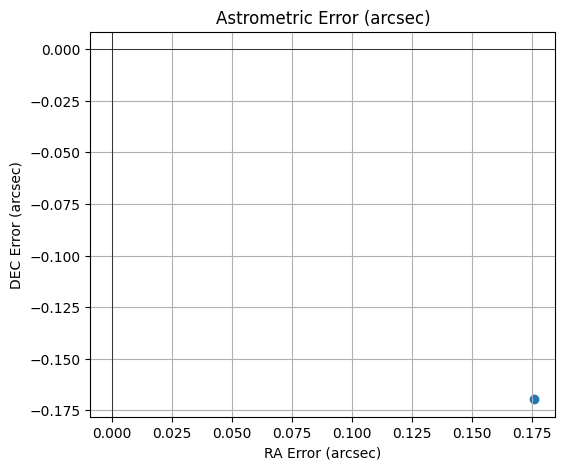

In [9]:
# ==============================================================
# CELL 4 — Simple Astrometry Solution
# ==============================================================

import numpy as np
from astropy.wcs import WCS
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# 1. True “sky model” (used only for error evaluation)
# --------------------------------------------------------------

# These must match your earlier simulation
RA0  = 150.00      # deg – reference RA used in sky simulation
DEC0 =  2.000      # deg – reference DEC used in sky simulation
PLATE_SCALE = 0.40 # arcsec/pixel (same used in PSF generation)

# Convert arcsec/pixel → deg/pixel
deg_per_pix = PLATE_SCALE / 3600.0

# --------------------------------------------------------------
# 2. Build a simple WCS model
# --------------------------------------------------------------
w = WCS(naxis=2)
w.wcs.crpix = [img.shape[1]/2, img.shape[0]/2]        # Reference pixel (center)
w.wcs.cdelt = np.array([-deg_per_pix, deg_per_pix])   # Pixel → degree scaling
w.wcs.crval = [RA0, DEC0]                             # Reference sky position
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]

print("WCS model created:")
print(w)

# --------------------------------------------------------------
# 3. Convert centroid pixel positions → RA/Dec
# --------------------------------------------------------------

pix_xy = np.array([[c[1], c[0]] for c in centroids])  # (x, y)
world = w.wcs_pix2world(pix_xy, 0)
RA_pred  = world[:,0]
DEC_pred = world[:,1]

# --------------------------------------------------------------
# 4. Compute error (compared to ideal simulated center)
# --------------------------------------------------------------

# True RA,Dec for all stars (simple assumption: all near field)
RA_true  = np.ones_like(RA_pred)  * RA0
DEC_true = np.ones_like(DEC_pred) * DEC0

RA_err_arcsec  = (RA_pred  - RA_true)  * 3600.0
DEC_err_arcsec = (DEC_pred - DEC_true) * 3600.0

# --------------------------------------------------------------
# 5. Print results
# --------------------------------------------------------------

print("\n===== ASTROMETRY RESULTS =====")
for i,(ra,dec,era,edec) in enumerate(zip(RA_pred, DEC_pred, RA_err_arcsec, DEC_err_arcsec)):
    print(f"Star {i+1}: RA={ra:.6f}°, DEC={dec:.6f}°,  ΔRA={era:.2f}\"  ΔDEC={edec:.2f}\"")

# --------------------------------------------------------------
# 6. Plot RA/Dec error
# --------------------------------------------------------------

plt.figure(figsize=(6,5))
plt.scatter(RA_err_arcsec, DEC_err_arcsec)
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)

plt.title("Astrometric Error (arcsec)")
plt.xlabel("RA Error (arcsec)")
plt.ylabel("DEC Error (arcsec)")
plt.grid(True)
plt.show()


Saved: astrometry_report.json


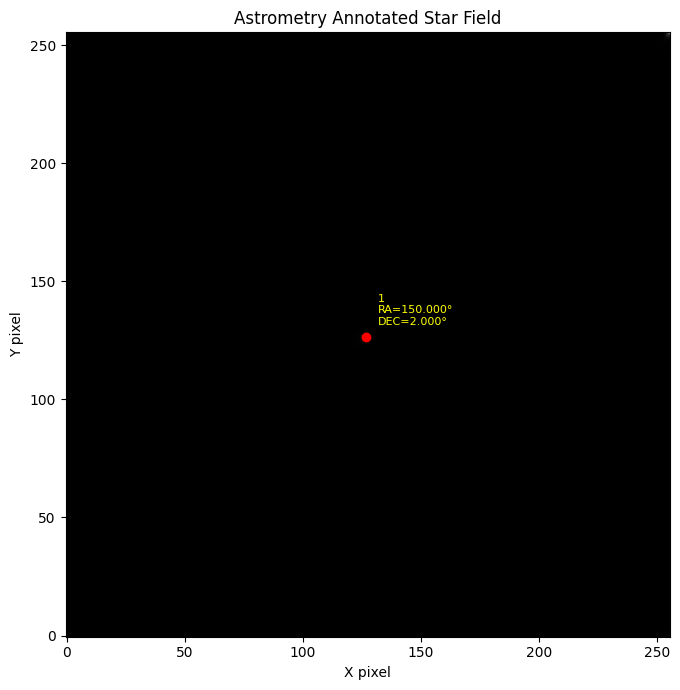

Saved: annotated_astrometry.png


In [10]:
# ==============================================================
# CELL 4 — Astrometry Report + Annotated Star Map
# ==============================================================

import json
import matplotlib.pyplot as plt

# --------------------------------------------------------------
# 1. Build Astrometry Report Dictionary
# --------------------------------------------------------------

report = {
    "reference_RA_deg": float(RA0),
    "reference_DEC_deg": float(DEC0),
    "plate_scale_arcsec_per_pixel": float(PLATE_SCALE),
    "num_detected_stars": int(len(centroids)),
    "stars": []
}

for i, (ra, dec, era, edec) in enumerate(zip(RA_pred, DEC_pred, RA_err_arcsec, DEC_err_arcsec)):
    report["stars"].append({
        "id": i + 1,
        "pixel_x": float(centroids[i][1]),
        "pixel_y": float(centroids[i][0]),
        "RA_deg": float(ra),
        "DEC_deg": float(dec),
        "RA_error_arcsec": float(era),
        "DEC_error_arcsec": float(edec)
    })

# Save JSON
json_path = "astrometry_report.json"
with open(json_path, "w") as f:
    json.dump(report, f, indent=4)

print("Saved:", json_path)


# --------------------------------------------------------------
# 2. Annotated Star Map
# --------------------------------------------------------------

plt.figure(figsize=(7,7))
plt.imshow(img, cmap="gray", origin="lower")
plt.title("Astrometry Annotated Star Field")

for i, (y, x) in enumerate(centroids):
    ra = RA_pred[i]
    dec = DEC_pred[i]
    label = f"{i+1}\nRA={ra:.3f}°\nDEC={dec:.3f}°"

    plt.plot(x, y, "ro", markersize=6)
    plt.text(x + 5, y + 5, label, color="yellow", fontsize=8)

plt.xlabel("X pixel")
plt.ylabel("Y pixel")
plt.tight_layout()

annot_path = "annotated_astrometry.png"
plt.savefig(annot_path, dpi=150)
plt.show()

print("Saved:", annot_path)
